In [22]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

## 2 - Process the MII tables

In [38]:
issues_table = pd.read_csv('MORI_table.csv', index_col=0)

issues_table = issues_table.replace('\xa0*\xa0', '*').replace('*\xa0', '*').replace('\xa0*', '*')
issues_table = issues_table.replace('*', 0.25).replace('\xa0', -1).replace('-', -1)

for key in issues_table:
    if key != 'month':
        issues_table[key] = [ float(i) for i in issues_table[key].values ]

issues_table = issues_table.drop(range(29))
issues_table = issues_table.drop([174])

del issues_table['Oth'] # Other
del issues_table['DK'] # Don't Know
issues_table.head()

,AG,AID,AW,BF,BSE,Coa,Com,Cou,Cri,Def,...,Rac,SA,SWA,TU,Tax,Tra,Tsu,Une,month,year
29,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,10.0,7.0,...,2.0,-1.0,-1.0,26.0,-1.0,-1.0,-1.0,82.0,Jan-85,1985.0
30,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,8.0,9.0,...,2.0,-1.0,-1.0,26.0,-1.0,-1.0,-1.0,79.0,Feb-85,1985.0
31,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,13.0,5.0,...,2.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,85.0,Mar-85,1985.0
32,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,12.0,6.0,...,4.0,-1.0,-1.0,9.0,-1.0,-1.0,-1.0,85.0,Apr-85,1985.0
33,0.25,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,15.0,7.0,...,4.0,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,85.0,May-85,1985.0


In [8]:
all_topics = {
 'AG' : 'Ageing Population/Social Care for the Elderly',
 'AID': 'AIDS',
 'AW' : 'Animal Welfare',
 'BF' : 'Bird Flu/Flu Pandemic',
 'BSE': 'BSE/Beef',
 'Coa': 'Coal Review/Pit Closures',
 'Com': 'Common Market/EU/Europe/Single European Currency',
 'Cou': 'Countryside/Rural Life',
 'Cri': 'Crime/Law & Order/Violence/Vandalism',
 'DK' : "Don't know",
 'Def': 'Defence/Foreign Affairs/International Terrorism',
 'Dru': 'Drug Abuse',
 'Eco': 'Economy/Economic Situation',
 'Edu': 'Education/Schools',
 'Foo': 'Foot And Mouth Outbreak/Farming Crisis',
 'GM' : 'GM/GM (Genetically Modified) Foods',
 'Ger': 'German Reunification/Eastern Europe',
 'Hea': 'Heathrow/third runway at Heathrow',
 'Hou': 'Housing',
 'Inf': 'Inflation/Prices',
 'Inn': 'Inner Cities',
 'Imm': 'Immigration',
 'Lac': 'Lack of faith in govt/politics',
 'LG' : 'Local Government/Council Tax/Poll Tax',
 'Low': 'Low Pay/Minimum Wage/Fair Wages',
 'Mor': 'Morality/Individual Behaviour',
 'NHS': 'NHS / Hospitals / Health Care',
 'Nat': 'Nationalisation/Government control of institutions',
 'NI' : 'Northern Ireland',
 'NP' : 'Nuclear Power/Fuels',
 'Nuc': 'Nuclear Weapons/Nuclear War/Disarmament',
 'Oth': 'Other',
 'Pen': 'Pensions/Social Security',
 'Pet': 'Petrol Prices/Fuel',
 'Pol': 'Pollution/Environment',
 'Pou': 'Pound/Exchange Rate/Value Of Pound',
 'Pov': 'Poverty/Inequality',
 'Pri': 'Privatisation',
 'Pub': 'Public Services In General',
 'Rac': 'Race Relations/Immigration/Immigrants',
 'SA' : 'Scottish Assembly',
 'SWA': 'Scottish/Welsh Assembly/Devolution Constitutional Reform',
 'TU' : 'Trade Unions/Strikes',
 'Tax': 'Taxation',
 'Tra': 'Transport/Public Transport',
 'Tsu': 'Tsunami/South East Asia',
 'Une': 'Unemployment/Factory Closure/Lack Of Industry'
}

In [10]:
MII_to_supertopics = {
'Ageing Population/Social Care for the Elderly' : 'Macroeconomic Policy',
'AIDS' : 'Social Policy',
'Animal Welfare' : 'Social Policy',
'Bird Flu/Flu Pandemic' : 'Social Policy',
'BSE/Beef' : 'Macroeconomic Policy',
'Coal Review/Pit Closures' : 'Environment and Natural Resources',
'Common Market/EU/Europe/Single European Currency' : 'Foreign Affairs and Defense',
'Countryside/Rural Life' : 'Social Policy',
'Crime/Law & Order/Violence/Vandalism' : 'Law, Order, and Civil Rights',
'Defence/Foreign Affairs/International Terrorism' : 'Foreign Affairs and Defense',
'Drug Abuse' : 'Social Policy',
'Economy/Economic Situation' : 'Macroeconomic Policy',
'Education/Schools' : 'Social Policy',
'Foot And Mouth Outbreak/Farming Crisis' : 'Macroeconomic Policy',
'GM/GM (Genetically Modified) Foods' : 'Macroeconomic Policy',
'German Reunification/Eastern Europe' : 'Foreign Affairs and Defense',
'Heathrow/third runway at Heathrow' : 'Macroeconomic Policy',
'Housing' : 'Social Policy',
'Inflation/Prices' : 'Macroeconomic Policy',
'Inner Cities' : 'Social Policy',
'Immigration' : 'Law, Order, and Civil Rights',
'Lack of faith in govt/politics' : 'Macroeconomic Policy',
'Local Government/Council Tax/Poll Tax' : 'Macroeconomic Policy',
'Low Pay/Minimum Wage/Fair Wages' : 'Macroeconomic Policy',
'Morality/Individual Behaviour' : 'Law, Order, and Civil Rights',
'NHS / Hospitals / Health Care' : 'Social Policy',
'Nationalisation/Government control of institutions' : 'Macroeconomic Policy',
'Northern Ireland' : 'Foreign Affairs and Defense',
'Nuclear Power/Fuels' : 'Environment and Natural Resources',
'Nuclear Weapons/Nuclear War/Disarmament' : 'Foreign Affairs and Defense',
'Pensions/Social Security' : 'Macroeconomic Policy',
'Petrol Prices/Fuel' : 'Environment and Natural Resources',
'Pollution/Environment' : 'Environment and Natural Resources',
'Pound/Exchange Rate/Value Of Pound' : 'Macroeconomic Policy',
'Poverty/Inequality' : 'Social Policy',
'Privatisation' : 'Macroeconomic Policy',
'Public Services In General' : 'Social Policy',
'Race Relations/Immigration/Immigrants' : 'Law, Order, and Civil Rights',
'Scottish Assembly' : 'Macroeconomic Policy',
'Scottish/Welsh Assembly/Devolution Constitutional Reform' : 'Macroeconomic Policy',
'Trade Unions/Strikes' : 'Macroeconomic Policy',
'Taxation' : 'Macroeconomic Policy',
'Transport/Public Transport' : 'Macroeconomic Policy',
'Tsunami/South East Asia' : 'Foreign Affairs and Defense',
'Unemployment/Factory Closure/Lack Of Industry' : 'Macroeconomic Policy'
}

In [39]:
new_keys = [ MII_to_supertopics[all_topics[k]] for k in issues_table.keys()[:-2] ]

superissues_table = pd.DataFrame()

for k in issues_table.keys()[:-2]:
    new_k = MII_to_supertopics[all_topics[k]]
    
    if new_k not in superissues_table.keys():
        superissues_table[new_k]  = issues_table[k]    
    else:
        superissues_table[new_k] += [ i if i>0 else 0 for i in issues_table[k] ]

for k in issues_table.keys()[-2:]:
    superissues_table[k] = issues_table[k]

In [40]:
dates = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y') \
         for m in superissues_table.month.values ]
superissues_table['date'] = dates
    
superissues_table.to_csv('MORI_superissues_table.csv')
superissues_table.head()

,Macroeconomic Policy,Social Policy,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",month,year,date
29,130.5,19.0,-1.0,37.0,12.25,Jan-85,1985.0,1985-01-01
30,141.5,29.0,-1.0,34.0,10.25,Feb-85,1985.0,1985-02-01
31,124.5,30.0,-1.0,30.0,15.25,Mar-85,1985.0,1985-03-01
32,117.5,33.0,-1.0,29.0,16.25,Apr-85,1985.0,1985-04-01
33,113.5,31.0,-1.0,29.0,19.25,May-85,1985.0,1985-05-01


In [41]:
issues_table = pd.read_csv('MORI_superissues_table.csv', index_col=0)

In [42]:
table = issues_table

table.drop(235)

all_entropies = []

for index, row in table.iterrows():
    #print( sum([ row[key]>0 for key in row.keys()[:-3] ])  )
    topic_array = np.array([ row[key]  for key in row.keys()[:-3] if row[key]>0 ])
    all_entropies += [ entropy(topic_array)*entropy_fix ]
all_entropies = np.array(all_entropies)

In [43]:
n_issues = []

for index, row in table.iterrows():
    n_issues += [ sum([ row[key]>0 for key in row.keys()[:-3] ]) ]
n_issues = np.array(n_issues)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


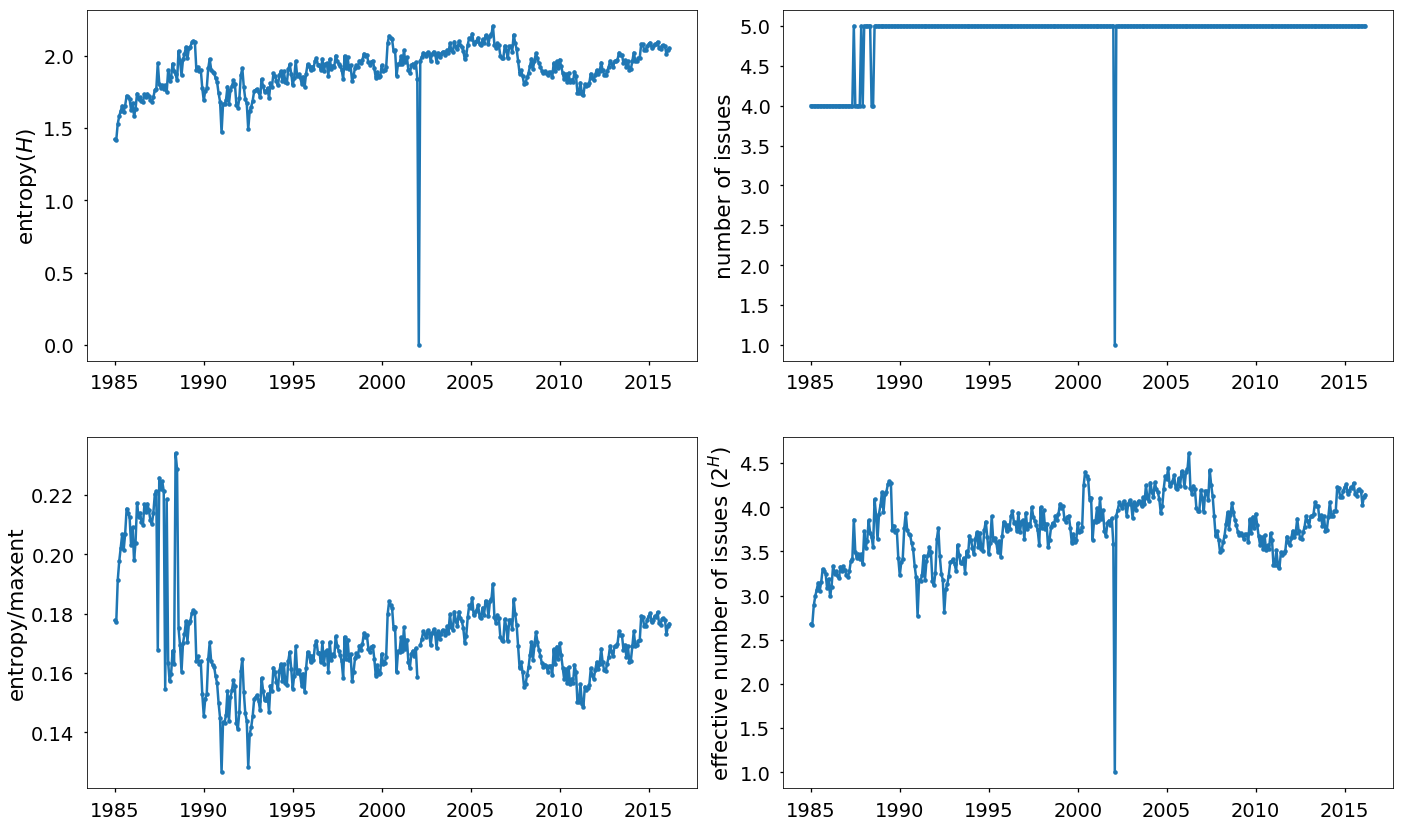

In [44]:
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

ys = [ [ s                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ n                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ s/(n*np.log2(n)) if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ 2**s             if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ]
     ]


xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ylabels = ['entropy($H$)', 'number of issues', 'entropy/maxent', r'effective number of issues ($2^H$)']
for ax,y,ylabel in zip(axs,ys,ylabels):
    ax.plot(issues_table.date, y, '.-')
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
plt.tight_layout()
plt.show()

The entropy of the MII distribution rises over time, but so does the number of issues included in the MII.

The effective number of issues, given by 2^(entropy), also increases. This says that there are more topics in the public mind, but it doesn't say whether they are changing.

This is also seen in the total number of answers, which also increases, but which does not affect entropy measures:

In [46]:
table = issues_table.replace(-1, 0)
month_table = table
month_table.to_csv('MORI_superissues_table.csv')

## 3 - Make novelty plots

In [48]:
month_table = pd.read_csv('MORI_superissues_table.csv', index_col=0)

month_table.head()

,Macroeconomic Policy,Social Policy,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",month,year,date
29,130.5,19.0,0.0,37.0,12.25,Jan-85,1985.0,1985-01-01
30,141.5,29.0,0.0,34.0,10.25,Feb-85,1985.0,1985-02-01
31,124.5,30.0,0.0,30.0,15.25,Mar-85,1985.0,1985-03-01
32,117.5,33.0,0.0,29.0,16.25,Apr-85,1985.0,1985-04-01
33,113.5,31.0,0.0,29.0,19.25,May-85,1985.0,1985-05-01


In [49]:
from scipy.spatial.distance import hamming

def novelty(p,q,metric='KL',ep=0.01, faz=True):
    
    if metric=='KL':
        return rel_entr(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='hamming':
        return hamming(p>0,q>0)
    else:
        return 0

    
def rel_entr(p, q, ep=0.01, fill_all_zeros=True):
    if fill_all_zeros is True:
        P = p.copy()
        Q = q.copy()   
        P[P==0] = ep
        Q[Q==0] = ep
        return entropy(list(P), list(Q))*entropy_fix
    
    else:
        P = p.copy()
        Q = q.copy()
        for i in zip(range(len(P))):
            if P[i] == 0:
                if Q[i] != 0:
                    P[i] = ep
                else: # Q[i] == 0
                    continue
            else:# P[i] != 0
                if P[i] != 0:
                    Q[i] = ep
                else: # P[i] == 0
                    continue
        return entropy(list(P), list(Q))*entropy_fix

In [51]:
table = month_table
issues_tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-3])
   
    for index, row in issues_tplus1.iterrows():
        topic_array = np.array(row.values[:-3])
        relative_entropies_True  += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(topic_array, previous_topic_array, metric='hamming') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm    

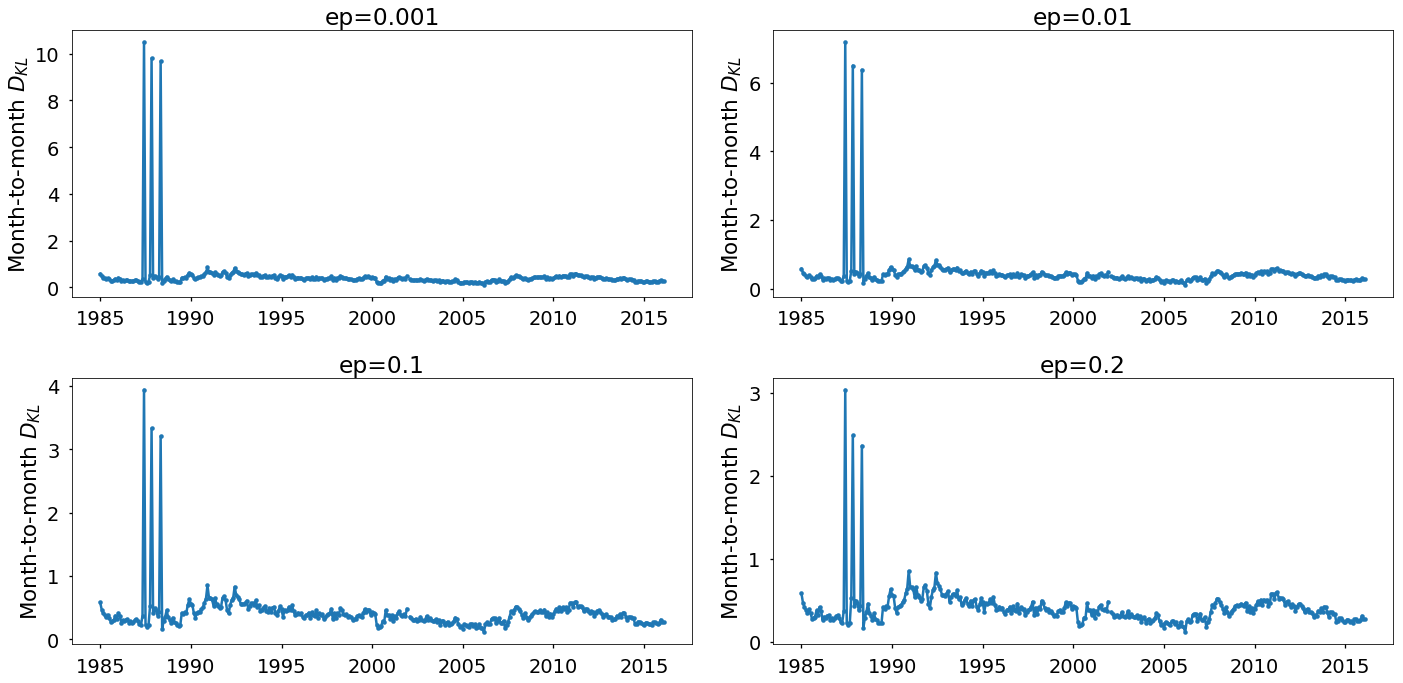

In [54]:
# Fill all zeros = False:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

for ep,ax in zip(eps,axs):
    ax.plot(month_table.date[1:], KLs_faz_False[ep], '.-')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-month $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_ylim(-0.1,9)
    
plt.tight_layout()
plt.show()

When filling only the zeros which are being compared to non-zero entries in the other month or year, the addition of new MIIs is a great surprise, reflecting in the high peaks in the earlier decades. Since those zeros are replaced by ep, lower values of ep such as ep=0.001 result in a higher surprise.

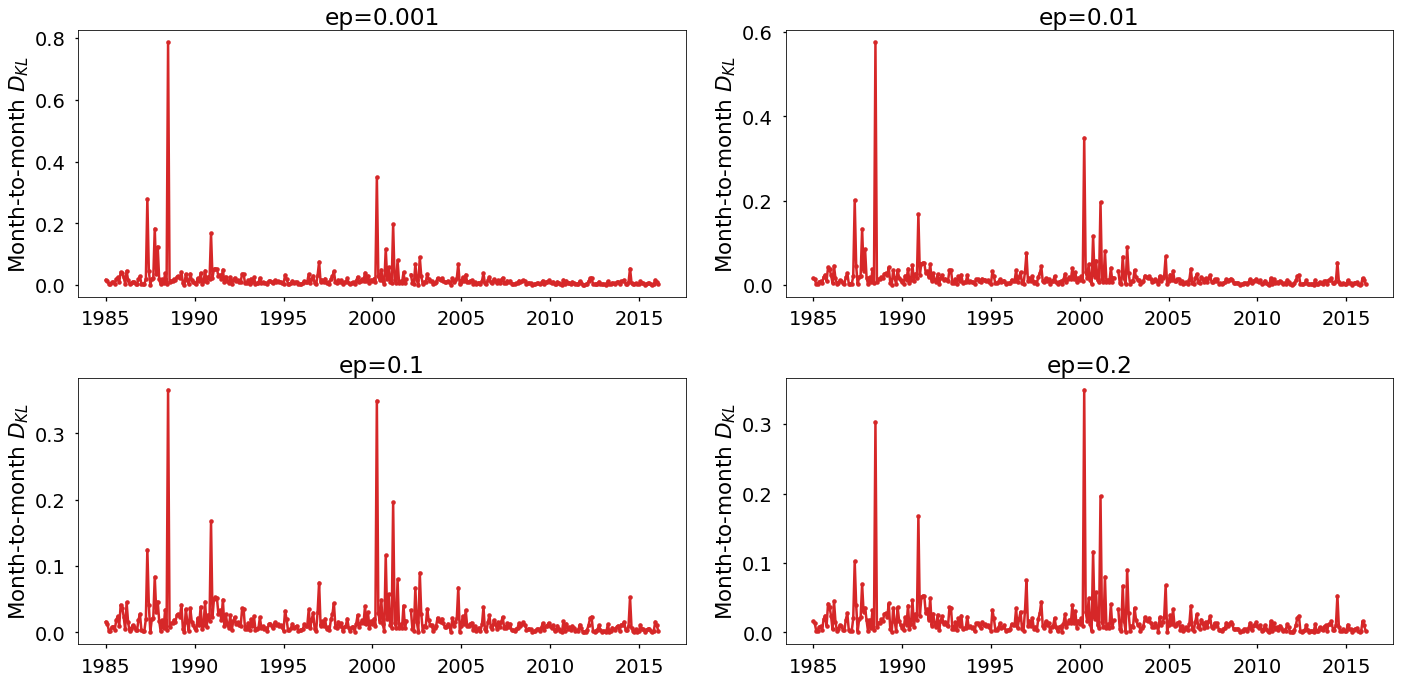

In [55]:
# Fill all zeros = True:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

for ep,ax in zip(eps,axs):
    ax.plot(month_table.date[1:], KLs_faz_True[ep], '.-', c='#d62728')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Month-to-month $D_{KL}$')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_ylim(-0.1,6)
    
plt.tight_layout()
plt.show()

When replacing all zeros with ep, the addition of new MIIs is still surprising, but less than what was shown above in blue. There are peaks in the earlier decades, but they are not as pronounced. Apart from that, the artificial parameter ep also does not make much difference here.

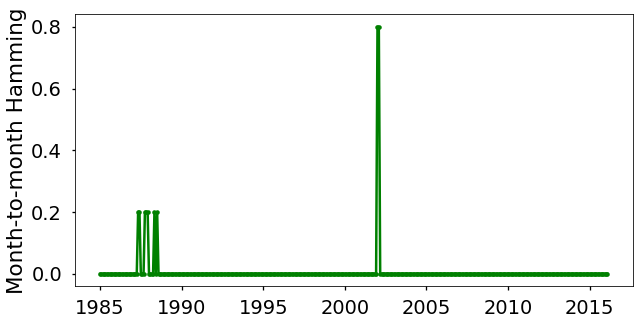

In [57]:
# Hamming distance
fig, ax = plt.subplots(1, figsize=(10,5))

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ax.plot(month_table.date[1:], hammings[ep], '.-', c='g')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month Hamming')
plt.show()

The month-to-month Hamming distance, which is not affected by MIIs of zero importance, shows the addition/removal of MIIs.

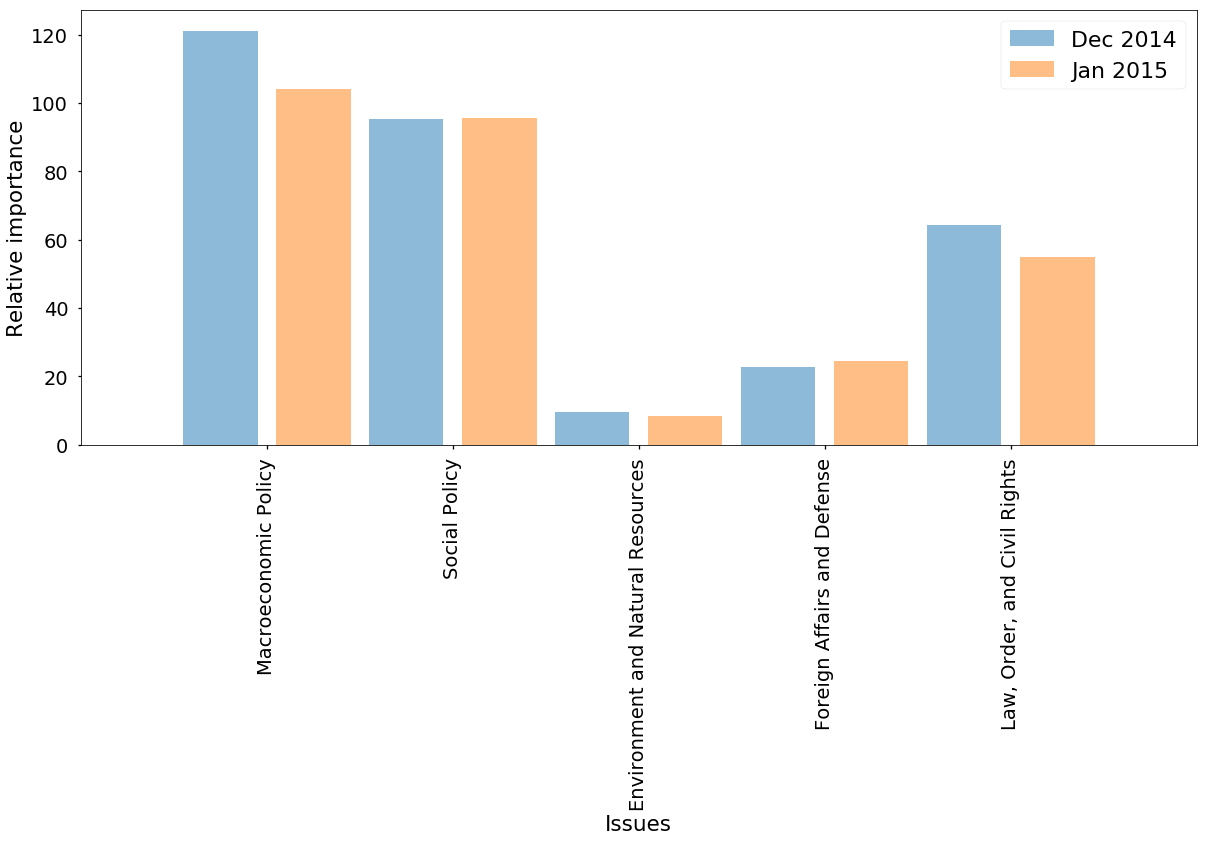

In [58]:
table = issues_table
keys = table.keys()[:-3]

v2014_12 = table[table.date=='2014-12-01'].values[0][:-3]
v2015_01 = table[table.date=='2015-01-01'].values[0][:-3]

v2014_12[v2014_12==0] = 0.01
v2014_12 = list(v2014_12)
v2015_01[v2015_01==0] = 0.01
v2015_01 = list(v2015_01)


fig, ax = plt.subplots(1, figsize=(20,8))

x = np.arange(len(keys))
ax.bar(2*x-1,  v2014_12, alpha=0.5, label='Dec 2014')
ax.bar(2*x,    v2015_01, alpha=0.5, label='Jan 2015')

ax.set_xticks(2*x-0.5)
ax.set_xticklabels(keys, rotation=90)
ax.set_xlim(-2.5,2*len(x)-0.5)
ax.set_xlabel('Issues')
ax.set_ylabel('Relative importance')

plt.legend(fontsize=22)
#plt.savefig('Dec2014-Jan2015.png',dpi=300)
plt.show()

Note that the issue "Rac", which stands for "Race Relations/Immigration/Immigrants", overlaps with "Imm", standing for "Immigrants", which was introduced in January 2015. This explains the sudden change in MII observed in this month -- not really a change of MII, but a change in categorisation. In the next steps, it might be better to merge topics like these.

In [59]:
month_table = pd.read_csv('MORI_superissues_table.csv', index_col=0)

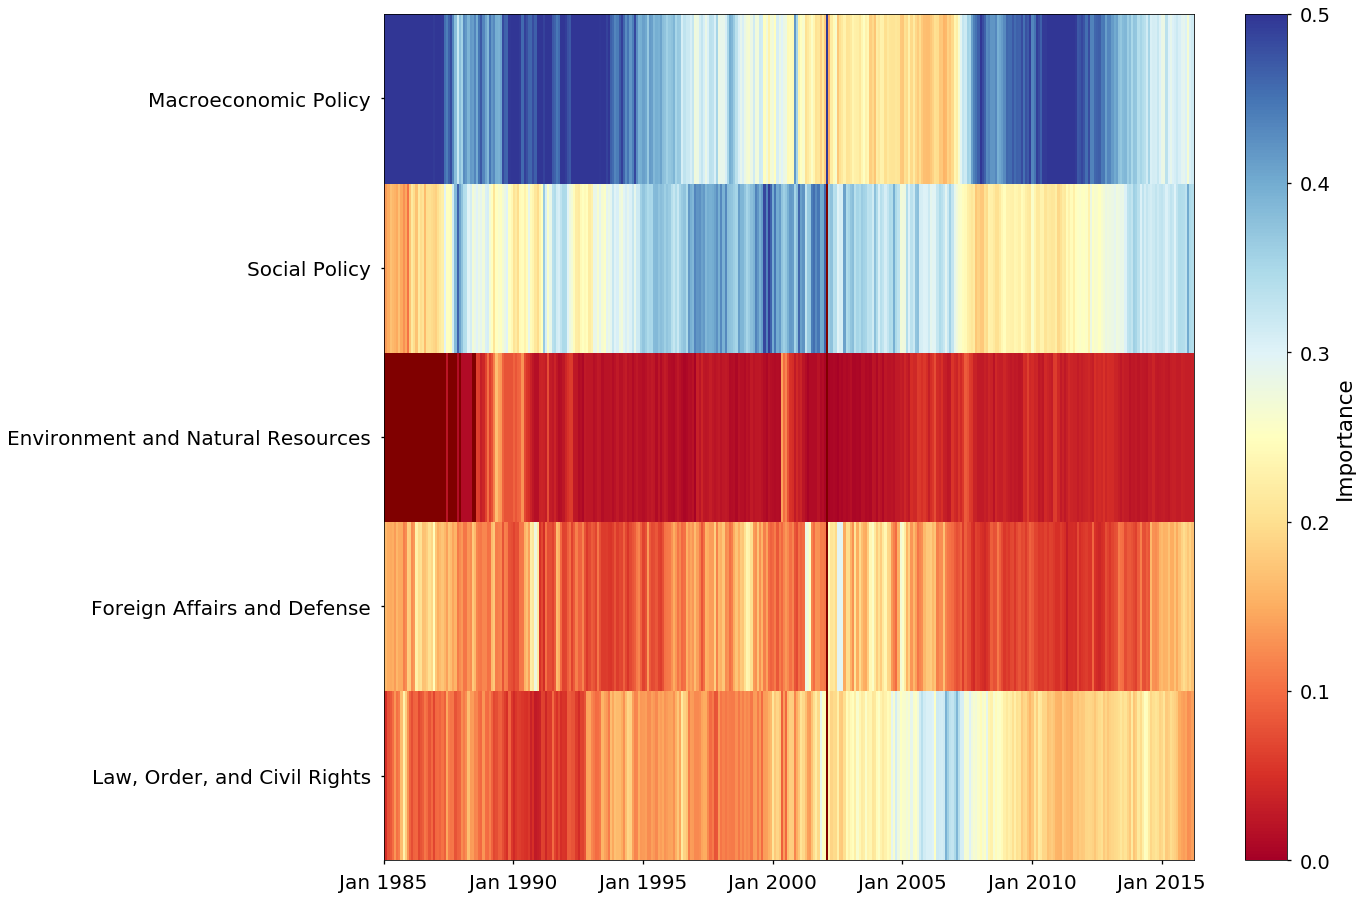

In [102]:
M = month_table.as_matrix()[:,:-3]
normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

fig, ax = plt.subplots(1, figsize=(20,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

keys = month_table.keys()[:-2]
yticks = np.arange(len(keys)-1)+0.5
yticklabels = list(reversed(keys.values[:-1]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=20)
#ax.set_ylabel('Issues')

xticks = np.arange(0,35*12,5*12)
xticklabels = [ 'Jan '+str(i) for i in np.arange(1985,2020,5) ]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=20)
#ax.set_xlabel('Months')

plt.tight_layout()
plt.savefig('images/Superissues-per-month.png', dpi=200)
plt.show()

This heatmap shows the importance of every issue over time. Rows are normalised.

Note how some issues such as the Tsunami in South East Asia, and the new runway at Heathrow are very temporary, while others (NHS..) seem to always be a MII. The list of all MIIs is presented in the end of this notebook. 

In particular, this heatmap shows how "Imm" standing for "Immigrants", was introduced in January 2015, leading to the sudden increase in this MII, and decrease in "Rac", which stands for "Race Relations/Immigration/Immigrants".

## 4 - What if we aggregate it by years?

In [65]:
years_range = [ int(i) for i in set(issues_table.year) ]
keys = issues_table.keys()[:-3]

issues_table = issues_table.replace(-1, 0)

stats_years = []
for year in years_range:
    stats_years += [ tuple( [ issues_table[ issues_table.year==year ][key].sum() for key in keys ] + [year] ) ]

cols = list(keys)+['year']
years_table = pd.DataFrame( stats_years, columns=cols)
years_table.head()

,Macroeconomic Policy,Social Policy,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",year
0,1358.00,328.0,0.0,345.0,271.0,1985
1,1147.00,418.0,0.0,401.0,186.0,1986
2,902.25,490.0,5.0,302.5,196.5,1987
3,1103.25,890.0,55.0,340.0,322.0,1988
4,1054.00,661.0,236.0,295.0,215.0,1989


In [66]:
table = years_table

all_entropies = []

for index, row in table.iterrows():
    topic_array = np.array([ row[key]  for key in row.keys()[:-1] if row[key]>0 ])
    all_entropies += [ entropy(topic_array)*entropy_fix ]
all_entropies = np.array(all_entropies)

In [67]:
n_issues = []

for index, row in table.iterrows():
    n_issues += [ sum([ row[key]>0 for key in row.keys()[:-1] ]) ]
n_issues = np.array(n_issues)

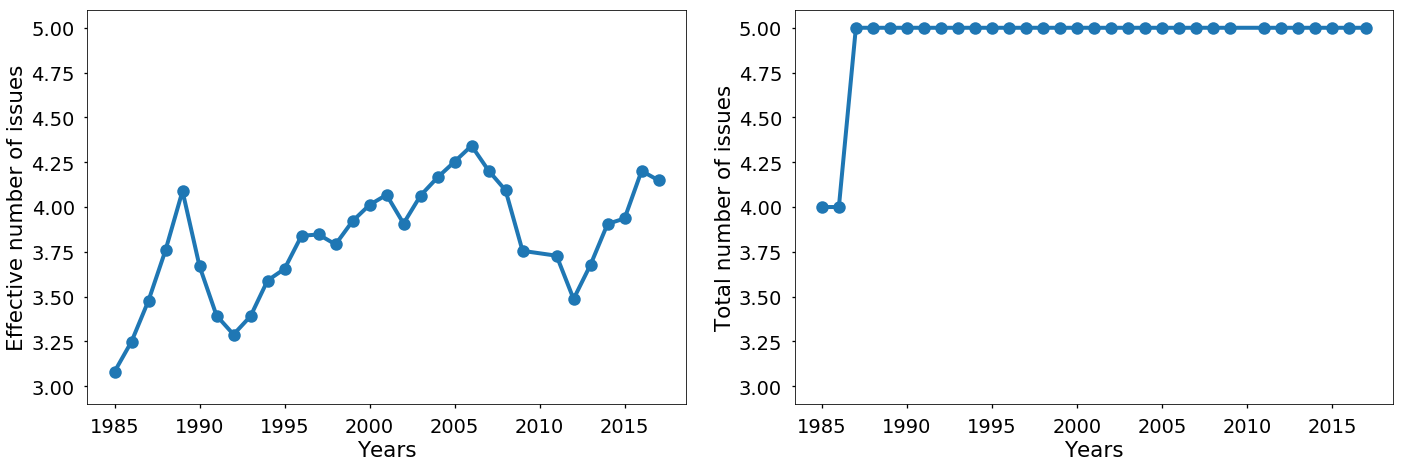

In [77]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

ax = axs[0]
ax.plot(table.year, 2**all_entropies,'.-',lw=4,ms=25)
ax.set_ylabel('Effective number of issues')
ax.set_xlabel('Years')
ax.set_ylim(2.9,5.1)

ax = axs[1]
ax.plot(table.year, n_issues,'.-',lw=4,ms=25)
ax.set_ylabel('Total number of issues')
ax.set_xlabel('Years')
ax.set_ylim(2.9,5.1)

plt.tight_layout()
plt.savefig('images/Entropy_superissues.png',dpi=200)
plt.show()

The yearly data shows the same behaviour as the monthly data: the entropy of the MII distribution rises over time, but so does the number of issues included in the MII. 

In [78]:
table = years_table
tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-1])
   
    for index, row in tplus1.iterrows():
        topic_array = np.array(row.values[:-1])
        relative_entropies_True  += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(topic_array, previous_topic_array, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(topic_array>0, previous_topic_array>0, metric='hamming') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    
year_table = table

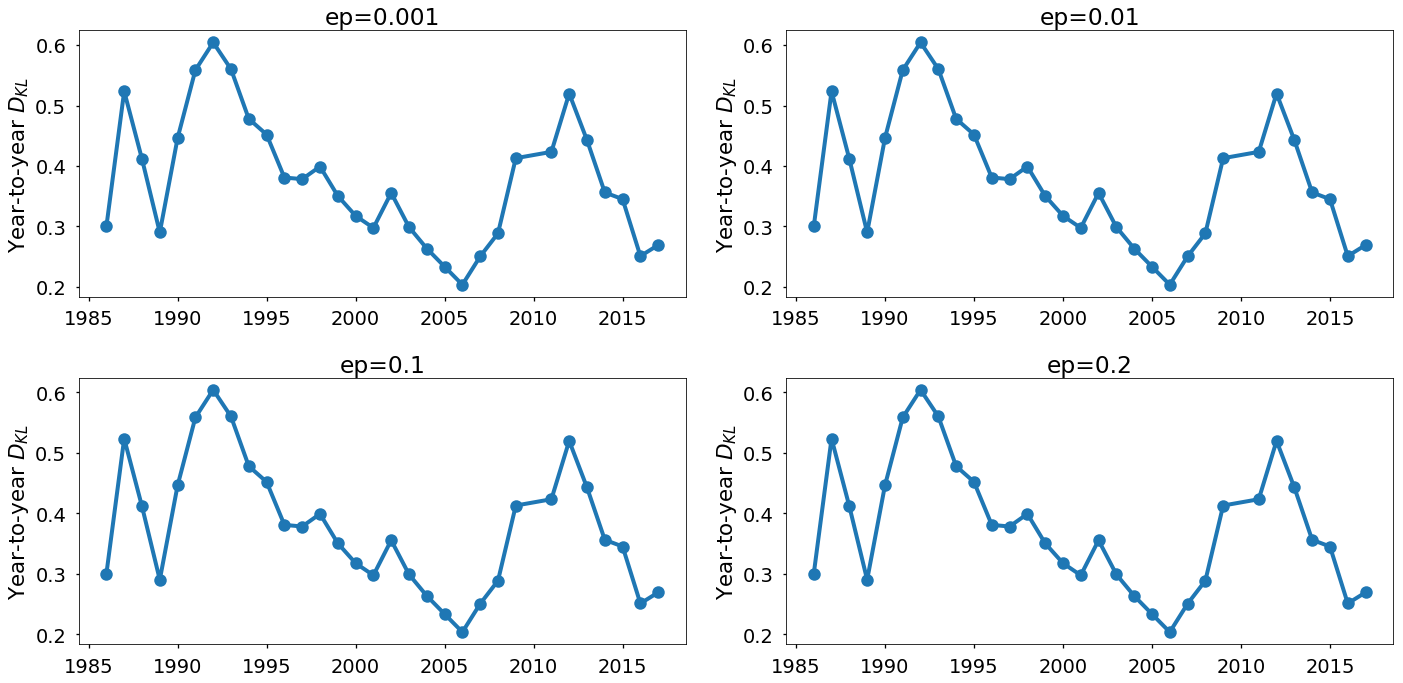

In [83]:
# Fill all zeros = False:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(year_table.year[1:], KLs_faz_False[ep], '.-',lw=4,ms=25)
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Year-to-year $D_{KL}$')
    
plt.tight_layout()
plt.show()

When aggregating over months, varying the value of ep when filling only the zeros which are being compared to non-zero entries in the other month or year makes no difference. Still, the addition of new MIIs is a great surprise, reflecting in the high peaks in the earlier decades.

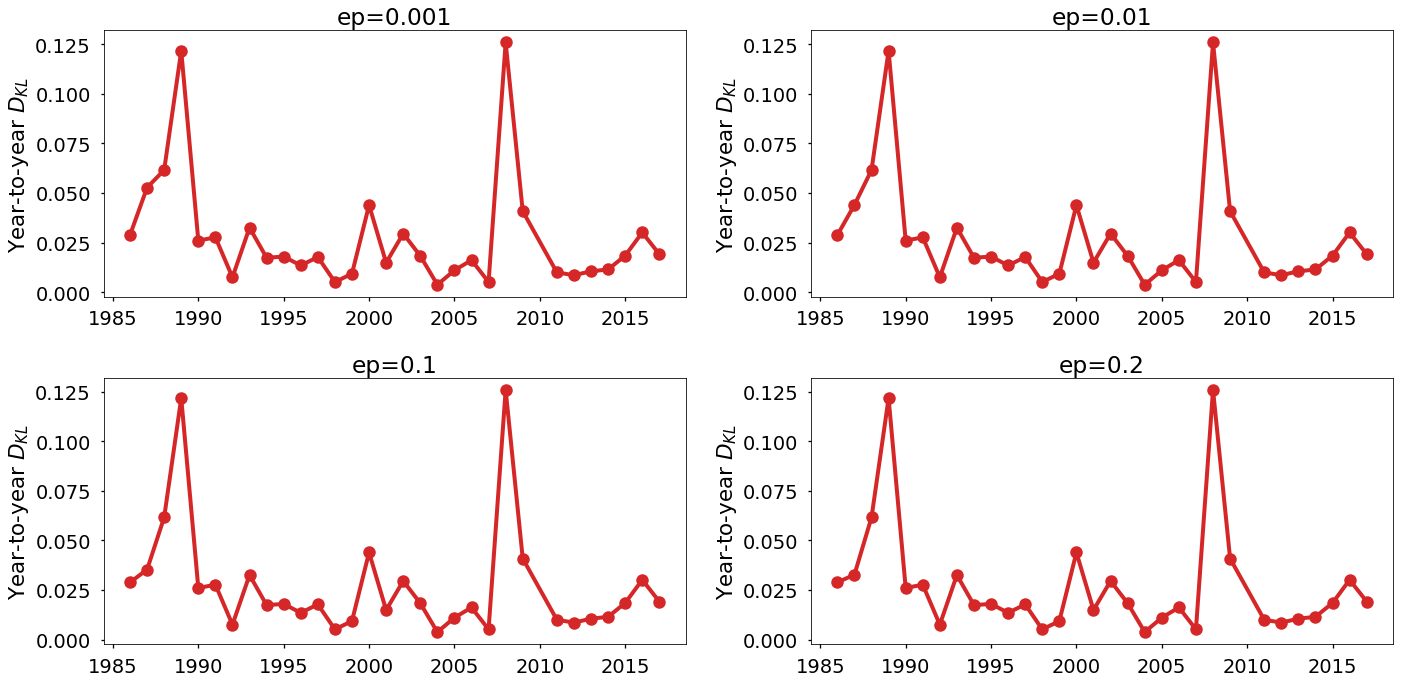

In [84]:
# Fill all zeros = True:

fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

for ep,ax in zip(eps,axs):
    ax.plot(year_table.year[1:], KLs_faz_True[ep], '.-',lw=4,ms=25, c='#d62728')
    ax.set_title('ep='+str(ep))
    ax.set_ylabel(r'Year-to-year $D_{KL}$')
    
plt.tight_layout()
plt.show()

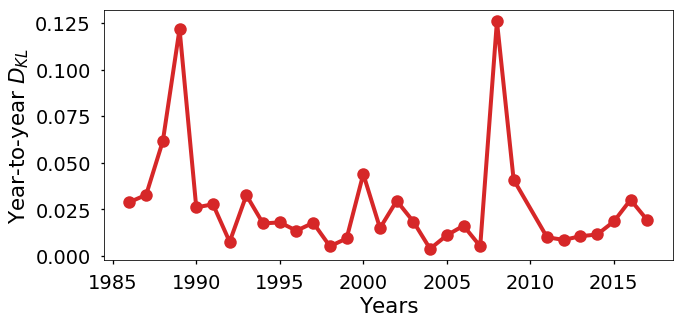

In [86]:
# For IC2S2

fig, ax = plt.subplots(1,figsize=(10,5))

x = year_table.year[1:]
y = KLs_faz_True[ep]

data = [ [i,j] for i,j in zip(x,y)]
#np.savetxt('MII.dat',data)

ax.plot(x, y, '.-',lw=4,ms=25, c='#d62728')
ax.set_ylabel(r'Year-to-year $D_{KL}$')
ax.set_xlabel('Years')

#plt.legend(['Public opinion'])
plt.tight_layout()
plt.savefig('Superissues_KL_per_year.png',dpi=200)
plt.show()

When replacing all zeros with ep, again, the  artificial parameter ep also does not make much difference, and the addition of new MIIs is not as surprising. The biggest peak comes from 2015, where we already know that new topics such as "Imm" were introduced, without the removal of "Rac".

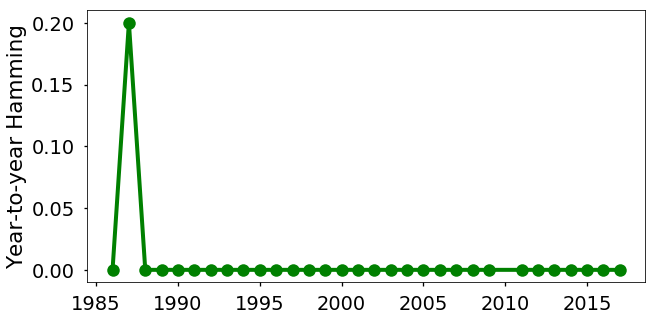

In [89]:
# Hamming distance
plt.figure(figsize=(10,5))

plt.plot(year_table.year[1:], hammings[ep], '.-',lw=4,ms=25, c='g')

plt.ylabel(r'Year-to-year Hamming')
plt.show()

When aggregating over months, the year-to-year Hamming distance still shows results similar to relative entropy.

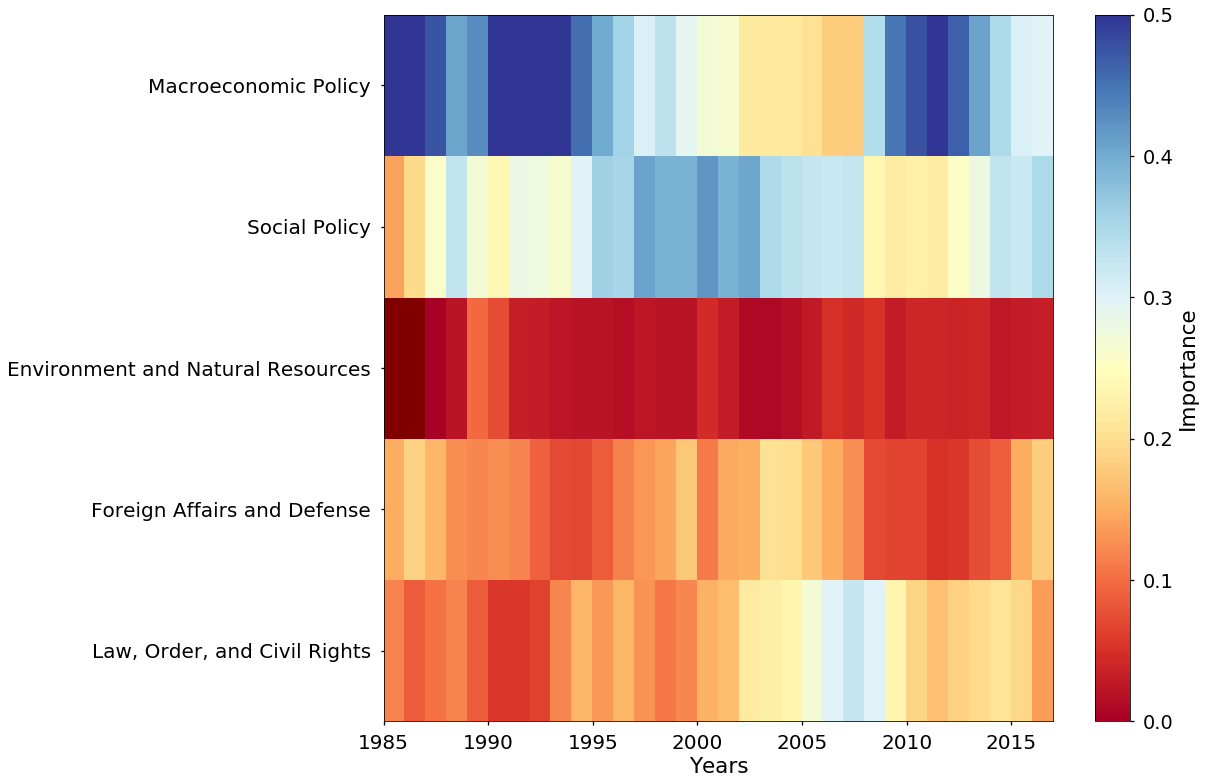

In [100]:
M = years_table.as_matrix()[:,:-1]
normM = np.array([ m/sum(m) for m in M ])

fig, ax = plt.subplots(1, figsize=(15,13))
#plt.figure(figsize=(15,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

yticks = np.arange(len(keys))+0.5
yticklabels = list(reversed(keys.values[:]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=20)
#ax.set_ylabel('Issues')

xticks = np.arange(0,35,5)
xticklabels = np.arange(1985,2020,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=20)
ax.set_xlabel('Years')

plt.savefig('Supperissues-per-year.png', dpi=200)
plt.show()

Same heatmap as above, but aggregated over years. Remember rows are normalised.